In [1]:
import string
import copy
import time
%matplotlib inline
import os
# os.listdir("../input/")
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
# os.system('pip install pytorch_pretrained_bert --no-index --find-links="../input/pytorch-pretrained-bert/pytorch_pretrained_bert" ')
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertModel
from transformers import RobertaTokenizer

from transformers import RobertaModel, AdamW
import random
from transformers import get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler, autocast
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

SEED = 42
BATCH_SIZE = 32
MAX_LENGTH = 356
ROBERTA_FP = '../input/roberta-base'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if n_gpu > 0:
    torch.cuda.manual_seed_all(SEED)

In [2]:
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [3]:
def children(m):
    return m if isinstance(m, (list, tuple)) else list(m.children())


def set_trainable_attr(m, b):
    m.trainable = b
    for p in m.parameters():
        p.requires_grad = b


def apply_leaf(m, f):
    c = children(m)
    if isinstance(m, nn.Module):
        f(m)
    if len(c) > 0:
        for l in c:
            apply_leaf(l, f)


def set_trainable(l, b):
    apply_leaf(l, lambda m: set_trainable_attr(m, b))

In [4]:
class RobertaForSequenceRegression(nn.Module):
    def __init__(self):
        super(RobertaForSequenceRegression, self).__init__()
        self.roberta = RobertaModel.from_pretrained(ROBERTA_FP)
        self.dropout = nn.Dropout(0.1)
        self.linear1 = nn.Linear(768, 256)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(256, 1)

    def forward(self, ids,  token_type_ids, attention_mask):
        _, pooled_output = self.roberta(ids, token_type_ids, attention_mask, return_dict=False)
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.linear1(pooled_output)
        pooled_output = self.relu(pooled_output)
        outputs = self.linear2(pooled_output)
        return outputs.view(-1)

In [5]:
def RMSELoss(outputs, targets):
    return torch.sqrt(nn.MSELoss()(outputs, targets))

In [6]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer

class regressor_stratified_cv:
    def __init__(self, n_splits = 10, n_repeats = 2, group_count = 10,
                 random_state = 0, strategy = 'quantile'):
        self.group_count = group_count
        self.strategy = strategy
        self.cvkwargs = dict(n_splits = n_splits, n_repeats = n_repeats, 
                             random_state = random_state)
        self.cv = RepeatedStratifiedKFold(**self.cvkwargs)
        self.discretizer = KBinsDiscretizer(n_bins = self.group_count, encode = 'ordinal',
                                            strategy = self.strategy)  
            
    def split(self, X, y, groups = None):
        kgroups=self.discretizer.fit_transform(y[:, None])[:, 0]
        return self.cv.split(X, kgroups, groups)
    
    def get_n_splits(self, X, y, groups = None):
        return self.cv.get_n_splits(X, y, groups)

In [7]:
def text_preprocessing(excerpt):
    
    # lower casing
    excerpt = excerpt.lower()

    # removal of punctuation
    excerpt = excerpt.translate(str.maketrans('', '', string.punctuation))

                
    return excerpt

In [8]:
df = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
df

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845
...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


In [9]:
df["text"] = df["excerpt"].apply(lambda x: text_preprocessing(x))

In [10]:
excerpts = df.text.values
targets = df.target.values

In [11]:
# Load the ROBERTA tokenizer.
tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_FP)

In [12]:
class TokenDataset(Dataset):
    def __init__(self, tokenizer, text, target = None, is_test=False):
        self.text = text
        self.target = target
        self.is_test = is_test
        self.max_len = MAX_LENGTH
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        text = str(self.text[idx])
        text = ' '.join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            truncation=True,
            add_special_tokens=True,
            max_length = self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long)
        token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long)
        
        if self.is_test:
            return {
                'ids': ids,
                'mask': mask,
                'token_type_ids': token_type_ids,
            }
        else:    
            targets = torch.tensor(self.target[idx], dtype=torch.float)
            return {
                'ids': ids,
                'mask': mask,
                'token_type_ids': token_type_ids,
                'targets': targets
            }

In [13]:
writer = SummaryWriter()

In [14]:
n_splits = 5
n_repeats = 1
group_count = 10

cv = regressor_stratified_cv(n_splits = n_splits, n_repeats = n_repeats,
                           group_count = group_count, random_state = 0, strategy = 'quantile')

df = df[['text', 'target']]

epochs = 30
n_epochs_stop = 10
epochs_no_improve = 0
training_stats = []
i = 1
eval_losses = []
scaler = GradScaler()
# input_ids, attention_masks, token_type_ids = encode(excerpts, tokenizer)
for train_idx, test_idx in cv.split(df["text"], df["target"].values):
    print('======== Fold {:}  ========'.format(i))
    train_data = df.loc[train_idx]
    test_data = df.loc[test_idx]
    
    train_set = TokenDataset(tokenizer,
                            text = train_data['text'].values,
                            target = train_data['target'].values
                           )
    
    test_set = TokenDataset(tokenizer,
                           text = test_data['text'].values,
                           target = test_data['target'].values
                          )

    train_dataloader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True, num_workers=8)

    test_dataloader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = True, num_workers=8)
    
    model = RobertaForSequenceRegression().to(device)
#     set_trainable(model, True)
#     set_trainable(model.roberta.embeddings, False)
#     set_trainable(model.roberta.encoder, False)
    # Defining Optimizer with weight decay to params other than bias and layer norms
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 
         'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0}
    ]  
    optimizer = AdamW(optimizer_parameters,
                      lr = 2e-5
                     )
    total_steps = (len(train_dataloader) * epochs)               
#     num_steps = int(total_steps * 0.1)
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)
    iter_eval_loss = []
    min_eval_loss = np.Inf
    for epoch_i in range(0, epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        t0 = time.time()
        # training
        model.train()
        tr_loss = []
        for step, batch in enumerate(train_dataloader):
            ids = batch['ids'].to(device, dtype=torch.long)
            input_mask = batch['mask'].to(device, dtype=torch.long)
            type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            target = batch['targets'].to(device, dtype=torch.float)
            optimizer.zero_grad()
            with autocast():
                output = model(ids, input_mask, type_ids)
                loss = RMSELoss(output, target)
                tr_loss.append(loss.cpu().detach().numpy().tolist())

            scheduler.step()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        train_losses = np.mean(tr_loss)  
        training_time = format_time(time.time() - t0)
        writer.add_scalar(f"Loss/train_fold_{i}_epoch_{epoch_i+1}", train_losses, epoch_i)
        print("Train loss: ", train_losses)
        print("Training epcoh took: {:}".format(training_time))
        
        # evaluation
        t0 = time.time()
        all_targets, all_preds = [], []
        model.eval()   
        eval_loss = []
        
        # disable gradients 
        with torch.no_grad(): 
            for batch in test_dataloader:
                ids = batch['ids'].to(device, dtype=torch.long)
                input_mask = batch['mask'].to(device, dtype=torch.long)
                type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
                target = batch['targets'].to(device, dtype=torch.float)
                output = model(ids, input_mask, type_ids)
                loss = RMSELoss(output, target)
                eval_loss.append(loss.cpu().detach().numpy().tolist())
            
        epoch_eval_loss = np.mean(eval_loss)
        eval_time = format_time(time.time() - t0)
        writer.add_scalar(f"Loss/eval_fold_{i}_epoch_{epoch_i+1}", epoch_eval_loss, epoch_i)
        print("Eval loss: ", epoch_eval_loss)
        print("Evaluation took: {:}".format(eval_time))
        
        # recording all statistics from this epoch
        training_stats.append({
            'fold' : i,
            'epoch': epoch_i + 1,
            'Training Loss': train_losses,
            'Eval Loss': epoch_eval_loss,
            'Training Time': training_time,
            'Eval Time': eval_time
        })
        
        # early stopping and saving best model
        if epoch_eval_loss < min_eval_loss:
            epochs_no_improve = 0
            min_eval_loss = epoch_eval_loss
            best_model = copy.deepcopy(model)
            PATH = f'model_fold_{i}_epoch_{epoch_i+1}_loss_{round(epoch_eval_loss, 3)}.pt'
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= n_epochs_stop:
            print('Early stopping! Epoch {:}'.format(epoch_i + 1) )
            break
        else:
            continue
    
    torch.save(best_model.state_dict(), PATH)    
    i += 1    
    torch.cuda.empty_cache()
writer.flush()
writer.close()

======== Fold 1  ========

======== Epoch 1 / 30 ========
Train loss:  0.8611027321345369
Training epcoh took: 0:01:27
Eval loss:  0.6249942961666319
Evaluation took: 0:00:08

======== Epoch 2 / 30 ========
Train loss:  0.5892554668473525
Training epcoh took: 0:01:25
Eval loss:  0.7140817377302382
Evaluation took: 0:00:08

======== Epoch 3 / 30 ========
Train loss:  0.49568979840883065
Training epcoh took: 0:01:25
Eval loss:  0.7159066879087024
Evaluation took: 0:00:08

======== Epoch 4 / 30 ========
Train loss:  0.4241904288950101
Training epcoh took: 0:01:25
Eval loss:  0.5781178308857812
Evaluation took: 0:00:08

======== Epoch 5 / 30 ========
Train loss:  0.36033862178594295
Training epcoh took: 0:01:25
Eval loss:  0.6643887725141313
Evaluation took: 0:00:08

======== Epoch 6 / 30 ========
Train loss:  0.302740238501992
Training epcoh took: 0:01:25
Eval loss:  0.6369844045903947
Evaluation took: 0:00:08

======== Epoch 7 / 30 ========
Train loss:  0.2644280558320838
Training epcoh 

In [15]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'fold' as the row index.
# df_stats = df_stats.set_index('fold')
df_stats

,fold,epoch,Training Loss,Eval Loss,Training Time,Eval Time
0,1,1,0.861103,0.624994,0:01:27,0:00:08
1,1,2,0.589255,0.714082,0:01:25,0:00:08
2,1,3,0.495690,0.715907,0:01:25,0:00:08
3,1,4,0.424190,0.578118,0:01:25,0:00:08
4,1,5,0.360339,0.664389,0:01:25,0:00:08
...,...,...,...,...,...,...
75,5,14,0.142218,0.630774,0:01:25,0:00:08
76,5,15,0.140954,0.589082,0:01:25,0:00:08
77,5,16,0.137369,0.582839,0:01:25,0:00:08
78,5,17,0.136095,0.640502,0:01:25,0:00:08


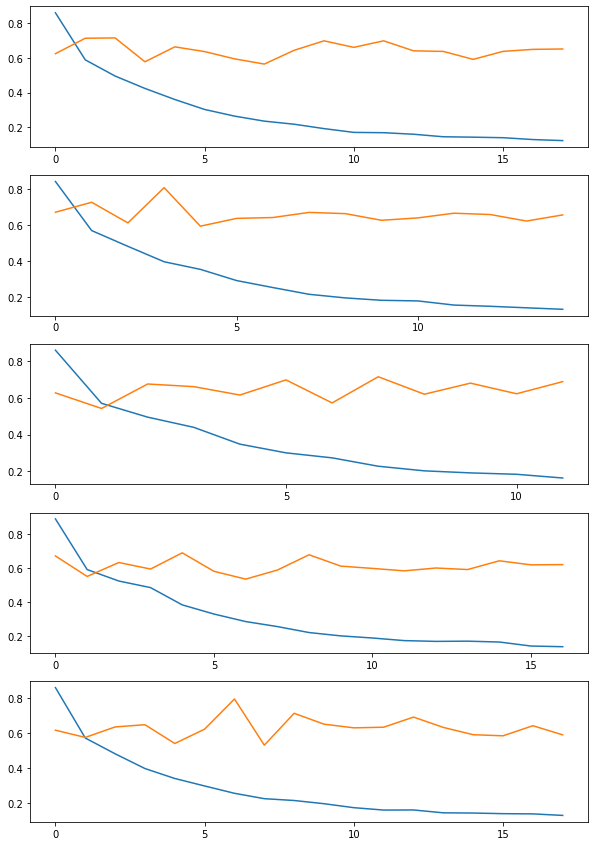

In [16]:
fig = plt.figure(figsize=(10, 15))
for fold in df_stats.fold.unique():
    ax = fig.add_subplot(5,1,fold)
    max_epoch = df_stats[df_stats['fold']==fold]['epoch'].max()
    x = np.arange(max_epoch)
    ax.plot(x,df_stats[df_stats['fold']==fold][['Training Loss']])
    ax.plot(x,df_stats[df_stats['fold']==fold][['Eval Loss']])
    plt.xticks(range(0, max_epoch, 5))

In [17]:
# n_splits = 5
# n_repeats = 2
# group_count = 10
# cv = regressor_stratified_cv(n_splits = n_splits, n_repeats = n_repeats,
#                            group_count = group_count, random_state = 0, strategy = 'quantile')

# for train_index, test_index in cv.split(input_ids, targets):
#     train_inputs, test_inputs = input_ids[train_index], input_ids[test_index]
#     train_targets, test_targets = targets[train_index], targets[test_index]
#     train_masks, test_masks = attention_masks[train_index], attention_masks[test_index]
#     train_type_ids, test_type_ids = token_type_ids[train_index], token_type_ids[test_index]

In [18]:
# train_inputs = torch.tensor(train_inputs, dtype=torch.long)
# test_inputs = torch.tensor(test_inputs, dtype=torch.long)
# train_targets = torch.tensor(train_targets, dtype=torch.float)
# test_targets = torch.tensor(test_targets, dtype=torch.float)
# train_masks = torch.tensor(train_masks, dtype=torch.long)
# test_masks = torch.tensor(test_masks, dtype=torch.long)
# train_type_ids = torch.tensor(train_type_ids, dtype=torch.long)
# test_type_ids = torch.tensor(test_type_ids, dtype=torch.long)

In [19]:
# train_data = TensorDataset(train_inputs, train_masks, train_type_ids, train_targets)
# train_sampler = RandomSampler(train_data)
# train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = BATCH_SIZE)

# test_data = TensorDataset(test_inputs, test_masks, test_type_ids, test_targets)
# test_sampler = RandomSampler(test_data)
# test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = BATCH_SIZE)

In [20]:
# set_trainable(model, True)
# set_trainable(model.bert.embeddings, True)    
# set_trainable(model.bert.encoder, True)

In [21]:
# epochs = 5
# optimizer = AdamW(model.parameters(),
#                   lr = 5e-6,
#                   eps = 1e-6 
#                 )
# total_steps = len(train_dataloader) * epochs
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps = 0,
#                                             num_training_steps = total_steps)
# eval_losses = []
# for epoch_i in range(0, epochs):
#     print("")
#     print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
#     # training
#     model.train()
#     tr_loss = []
    
#     for step, batch in enumerate(train_dataloader):
#         batch = tuple(t.to(device) for t in batch)
#         ids, input_mask, type_ids, target = batch
#         output = model(ids, input_mask, type_ids, target)
#         loss = RMSELoss(output, target)
#         tr_loss.append(loss.cpu().detach().numpy().tolist())
#         loss.backward()  
#         optimizer.step()
#         optimizer.zero_grad()  
#         scheduler.step()
            
#     train_losses = np.mean(tr_loss)  
#     print("Train loss: ", train_losses)
#     all_targets, all_preds = [], []
#     model.eval()   
#     eval_loss = []
#     # evaluation
#     # disable gradients 
#     with torch.no_grad(): 
#         for batch in test_dataloader:
#             batch = tuple(t.to(device) for t in batch)
#             ids, input_mask, type_ids, target = batch
#             output = model(ids, input_mask, type_ids, target)
#             loss = RMSELoss(output, target)
#         eval_loss.append(loss.cpu().detach().numpy().tolist())
            
#     epoch_eval_loss = np.mean(eval_loss)
#     print("Eval loss: ", epoch_eval_loss)

#     eval_losses.append(epoch_eval_loss)   
# torch.cuda.empty_cache()
# mean_eval_loss = np.mean(eval_losses)
# print(mean_eval_loss)

In [22]:
# test = pd.read_csv('../input/commonlitreadabilityprize/test.csv')

In [23]:
# test["text"] = test["excerpt"].apply(lambda x: text_preprocessing(x))

In [24]:
# excerpts = test.text.values

In [25]:
# # convert sentences into tokens
# input_ids = [tokenizer.encode(excerpt, add_special_tokens = True, max_length = MAX_LENGTH,
#                               padding='max_length') for excerpt in excerpts]

# input_ids = np.array(input_ids)
# attention_masks = []
# # create a mask of 1 for all input tokens and 0 for all padding tokens
# attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
# attention_masks = np.array(attention_masks)
# # create token type ids
# token_type_ids = [[0 for i in seq] for seq in input_ids]
# token_type_ids = np.array(token_type_ids)

In [26]:
# input_ids = torch.tensor(input_ids, dtype=torch.long)
# attention_masks = torch.tensor(attention_masks, dtype=torch.long)
# token_type_ids = torch.tensor(token_type_ids, dtype=torch.long)

In [27]:
# prediction_data = TensorDataset(input_ids, attention_masks, token_type_ids)
# prediction_sampler = SequentialSampler(prediction_data)
# prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=BATCH_SIZE)

In [28]:
# model.eval()   
# predictions , true_labels = [], []
# # evaluation
# for batch in prediction_dataloader:
#     # disable gradients 
#     batch = tuple(t.to(device) for t in batch)
#     ids, input_mask, type_ids = batch
#     with torch.no_grad():    
#         output = model(ids, input_mask, type_ids) 
#     output = output.cpu().detach().numpy().tolist()
#     predictions += output

In [29]:
# submission = pd.DataFrame({'id':test['id'],'target':predictions})

In [30]:
# submission.to_csv('submission.csv',index=False)

In [31]:
# torch.cuda.empty_cache()